### Load data

In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local").appName("Music").getOrCreate()
from pyspark.sql.types import *
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.linalg import DenseVector
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

/Users/hli/anaconda/envs/carnd-term1/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
df = spark.read.csv('../data/df_model_final.csv',header=True,inferSchema=True).cache()
df.show(5)

+---------+-----+-------------+-------------+-------------+--------------+--------------+-------------+-------------+-------------+--------------+--------------+-------------+-------------+-------------+--------------+--------------+-----------------+-----------------+-----------------+-------------------------------+--------------+-----------------------+-----------------------+-----------------------+------------------------+------------------------+--------------------+--------------------+--------------------+---------------------+---------------------+-----------+
|      uid|label|freq_P_last_1|freq_P_last_3|freq_P_last_7|freq_P_last_14|freq_P_last_30|freq_D_last_1|freq_D_last_3|freq_D_last_7|freq_D_last_14|freq_D_last_30|freq_S_last_1|freq_S_last_3|freq_S_last_7|freq_S_last_14|freq_S_last_30|days_since_last_P|days_since_last_D|days_since_last_S|days_since_last_['P', 'D', 'S']|sum(play_time)|total_play_time__last_1|total_play_time__last_3|total_play_time__last_7|total_play_time__l

In [3]:
df

DataFrame[uid: int, label: int, freq_P_last_1: int, freq_P_last_3: int, freq_P_last_7: int, freq_P_last_14: int, freq_P_last_30: int, freq_D_last_1: int, freq_D_last_3: int, freq_D_last_7: int, freq_D_last_14: int, freq_D_last_30: int, freq_S_last_1: int, freq_S_last_3: int, freq_S_last_7: int, freq_S_last_14: int, freq_S_last_30: int, days_since_last_P: int, days_since_last_D: int, days_since_last_S: int, days_since_last_['P', 'D', 'S']: int, sum(play_time): double, total_play_time__last_1: double, total_play_time__last_3: double, total_play_time__last_7: double, total_play_time__last_14: double, total_play_time__last_30: double, engaged_play__last_1: int, engaged_play__last_3: int, engaged_play__last_7: int, engaged_play__last_14: int, engaged_play__last_30: int, device_type: int]

### Prepare training data

In [4]:
selected_features = df.columns
selected_features.remove('uid')
selected_features.remove('label')
selected_features

['freq_P_last_1',
 'freq_P_last_3',
 'freq_P_last_7',
 'freq_P_last_14',
 'freq_P_last_30',
 'freq_D_last_1',
 'freq_D_last_3',
 'freq_D_last_7',
 'freq_D_last_14',
 'freq_D_last_30',
 'freq_S_last_1',
 'freq_S_last_3',
 'freq_S_last_7',
 'freq_S_last_14',
 'freq_S_last_30',
 'days_since_last_P',
 'days_since_last_D',
 'days_since_last_S',
 "days_since_last_['P', 'D', 'S']",
 'sum(play_time)',
 'total_play_time__last_1',
 'total_play_time__last_3',
 'total_play_time__last_7',
 'total_play_time__last_14',
 'total_play_time__last_30',
 'engaged_play__last_1',
 'engaged_play__last_3',
 'engaged_play__last_7',
 'engaged_play__last_14',
 'engaged_play__last_30',
 'device_type']

In [5]:
# training data
assembler = VectorAssembler(
    inputCols=selected_features,
    outputCol="features")
data = assembler.transform(df).select('label', 'features')

# train test split
(train, test) = data.randomSplit([0.7, 0.3], seed=1)

### Fit logistic regression

In [6]:
lr = LogisticRegression()

# Run cross-validation, and choose the best set of parameters.
paramGrid = ParamGridBuilder() \
    .addGrid(lr.maxIter, [10, 20, 30, 40]) \
    .addGrid(lr.regParam, [0.3, 0.1, 0.01]) \
    .build()
    
crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=4) 

cvModel = crossval.fit(train)
print('The best maxIter: {}'.format(cvModel.bestModel._java_obj.getMaxIter()))
print('The best regParam: {}'.format(cvModel.bestModel._java_obj.getRegParam()))

The best maxIter: 20
The best regParam: 0.01


/Users/hli/anaconda/envs/carnd-term1/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


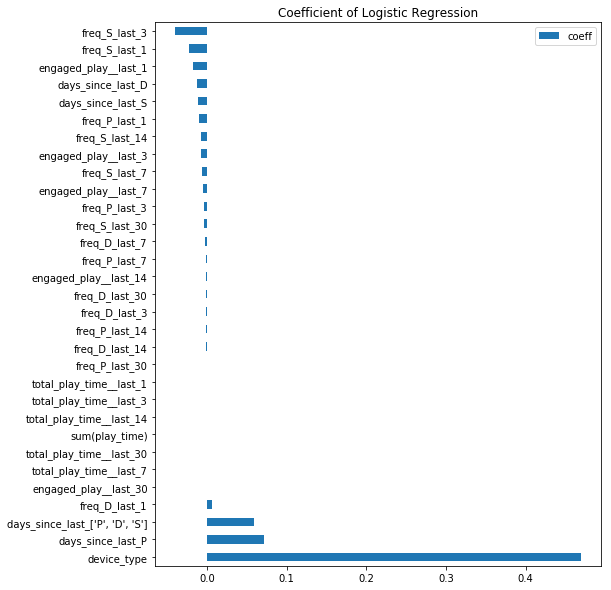

In [7]:
import matplotlib.pyplot as plt, pandas as pd, numpy as np
%matplotlib inline
lrCoeffs = pd.DataFrame(list(zip(selected_features, cvModel.bestModel.coefficients)), columns = ['feature', 'coeff']).sort_values(by="coeff", ascending=False)
ax =  lrCoeffs.plot.barh(figsize=(8, 10))
t = np.arange(lrCoeffs.shape[0])
ax.set_yticks(t)
ax.set_yticklabels(lrCoeffs['feature'])
ax.set_title("Coefficient of Logistic Regression")
plt.show()

### Predict and Evaluate performance

In [8]:
#### predict and evaluate performance

# Predict train data
predictions_train = cvModel.transform(train)

# Select example rows to display.
predictions_train.select("probability","prediction", "label", "features").show(5)
res_train = predictions_train.select("probability","prediction", "label").toPandas()


# Predict test data
predictions_test = cvModel.transform(test)
res_test = predictions_test.select("probability","prediction", "label").toPandas()


+--------------------+----------+-----+--------------------+
|         probability|prediction|label|            features|
+--------------------+----------+-----+--------------------+
|[0.73355161462454...|       0.0|    0|(31,[0,1,2,3,4,5,...|
|[0.74711005351219...|       0.0|    0|(31,[0,1,2,3,4,5,...|
|[0.92172995405596...|       0.0|    0|(31,[0,1,2,3,4,5,...|
|[0.68133915986314...|       0.0|    0|(31,[0,1,2,3,4,5,...|
|[0.67203887904506...|       0.0|    0|(31,[0,1,2,3,4,5,...|
+--------------------+----------+-----+--------------------+
only showing top 5 rows



### Evaluate performance

In [9]:
%matplotlib inline
from sklearn.metrics import roc_curve, auc, roc_auc_score
import sklearn.metrics
import pandas as pd
import numpy as np


# helper
def plot_roc_curve(y_train, y_train_pred, y_test, y_test_pred):
    """
    Plot ROC curves for the training set and the test set
    """
    roc_auc_train = roc_auc_score(y_train, y_train_pred)
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred)

    roc_auc_test = roc_auc_score(y_test, y_test_pred)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred)
    plt.figure()
    lw = 2
    plt.plot(fpr_train, tpr_train, color='green',
             lw=lw, label='ROC Train (AUC = %0.4f)' % roc_auc_train)
    plt.plot(fpr_test, tpr_test, color='darkorange',
             lw=lw, label='ROC Test (AUC = %0.4f)' % roc_auc_test)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()


def plot_cumulative_gains(lift: pd.DataFrame):
    """
    Plot cumulative gains 
    Reference: https://analyticsgyanblog.wordpress.com/category/lift-curve/
    http://www2.cs.uregina.ca/~dbd/cs831/notes/lift_chart/lift_chart.html
    """
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(10)
    fig.canvas.draw()

    handles = []
    handles.append(ax[0].plot(lift['numCases'], lift['TP'], 'r-', label='gains'))
    handles.append(ax[0].plot(lift['numCases'], lift['randP'], 'b-', label='baseline'))
    ax[0].set_xlabel('Number of Cases')
    ax[0].set_ylabel('Gains')
    ax[0].legend()
    ax[0].set_title('Cumulative Gain Chart')
    fig.show()
    
    ax[1].plot(lift['proportionOfCases'], lift['lift'], 'r-', label='lift curve')
    ax[1].plot(lift['proportionOfCases'], lift['baseline'], 'b-', label='baseline')
    ax[1].set_ylabel('Lift Curve')
    ax[1].set_xlabel('Cumulative Proportion of Cases')
    ax[1].set_title('Lift Chart')
    plt.tight_layout()
    
def calc_cumulative_gains(df: pd.DataFrame, actual_col: str, predicted_col:str, probability_col:str):
    """
    Generate the performance chart plot gains and lift
    Reference: https://stackoverflow.com/questions/42699243/how-to-build-a-lift-chart-a-k-a-gains-chart-in-python
    """
    lift = df.sort_values(by=probability_col, ascending=False)
    numChurn = sum(lift[actual_col] == True)
    numCases = lift.shape[0]
    randProb = numChurn / numCases
    lift['numCases'] = range(1, numCases+1)
    # Gain Chart
    lift['TP'] = lift[actual_col].cumsum()
    lift['randP'] = randProb
    lift['randP'] = lift['randP'].cumsum()
    # Lift Chart
    lift['proportionOfChurnCaptured'] = lift['TP'] / numChurn
    lift['proportionOfCases'] = lift['numCases'] / numCases
    lift['lift'] = lift['proportionOfChurnCaptured'] / lift['proportionOfCases']
    lift['baseline'] = 1
    plot_cumulative_gains(lift)
    return lift    



/Users/hli/anaconda/envs/carnd-term1/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/hli/anaconda/envs/carnd-term1/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/hli/anaconda/envs/carnd-term1/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/hli/anaconda/envs/carnd-term1/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


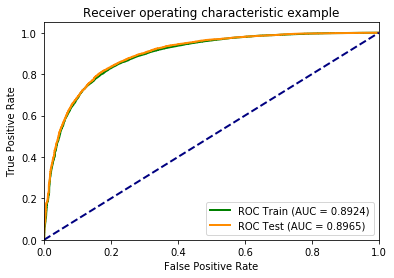

In [10]:
# Plot ROC curves for the training set and the test set
y_train = res_train['label']
res_train['probability'] = [v[1] for v in res_train['probability']]
y_train_pred = res_train['probability']
y_test = res_test['label']
res_test['probability'] = [v[1] for v in res_test['probability']]
y_test_pred = res_test['probability']

plot_roc_curve(y_train, y_train_pred, y_test, y_test_pred)

/Users/hli/anaconda/envs/carnd-term1/lib/python3.5/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


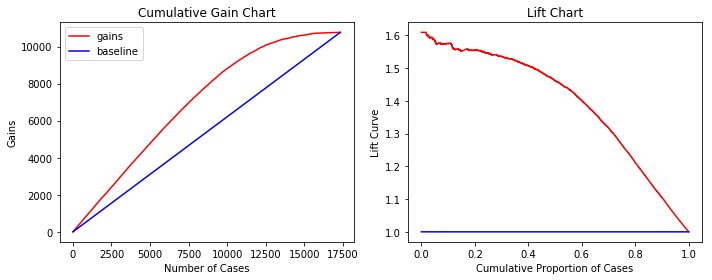

In [11]:
model_gain = calc_cumulative_gains(res_test, 'label',"prediction", "probability")

In [12]:
model_gain

,probability,prediction,label,numCases,TP,randP,proportionOfChurnCaptured,proportionOfCases,lift,baseline
15601,9.574386e-01,1.0,1,1,1,0.621307,0.000093,0.000058,1.609511,1
15554,9.572642e-01,1.0,1,2,2,1.242613,0.000186,0.000115,1.609511,1
15536,9.570221e-01,1.0,1,3,3,1.863920,0.000279,0.000173,1.609511,1
15312,9.569969e-01,1.0,1,4,4,2.485226,0.000372,0.000231,1.609511,1
15274,9.569515e-01,1.0,1,5,5,3.106533,0.000464,0.000289,1.609511,1
15096,9.568925e-01,1.0,1,6,6,3.727839,0.000557,0.000346,1.609511,1
15190,9.568825e-01,1.0,1,7,7,4.349146,0.000650,0.000404,1.609511,1
15095,9.568728e-01,1.0,1,8,8,4.970452,0.000743,0.000462,1.609511,1
14963,9.568697e-01,1.0,1,9,9,5.591759,0.000836,0.000519,1.609511,1
15431,9.568301e-01,1.0,1,10,10,6.213066,0.000929,0.000577,1.609511,1


### Random Forest

In [13]:
rf = RandomForestClassifier(labelCol="label", featuresCol="features"
                            ,featureSubsetStrategy="auto"
                            ,impurity='gini'
                            ,maxDepth=20
                            ,minInstancesPerNode=10
                            ,maxBins=16
                            , seed=42
                            )
# Run cross-validation, and choose the best set of parameters.
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [50, 100, 150]) \
    .build()
    
crossval = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=4) 

cvModel = crossval.fit(train)
print('The best numTrees: {}'.format(cvModel.bestModel._java_obj.getNumTrees()))

The best numTrees: 150


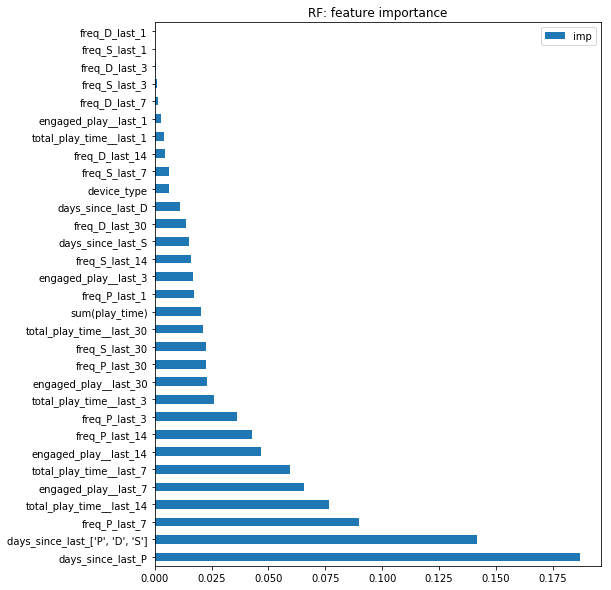

In [14]:
rfImp = pd.DataFrame(list(zip(selected_features, cvModel.bestModel.featureImportances.toArray())), columns = ['feature', 'imp']).sort_values(by="imp", ascending=False)
ax =  rfImp.plot.barh(figsize=(8, 10))
t = np.arange(rfImp.shape[0])
ax.set_yticks(t)
ax.set_yticklabels(rfImp['feature'])
ax.set_title("RF: feature importance")
plt.show()

In [15]:
#### predict and evaluate performance

# Predict train data
predictions_train = cvModel.transform(train)

# Select example rows to display.
predictions_train.select("probability","prediction", "label", "features").show(5)
res_train = predictions_train.select("probability","prediction", "label").toPandas()


# Predict test data
predictions_test = cvModel.transform(test)

# Select example rows to display.
predictions_test.select("probability","prediction", "label", "features").show(5)
res_test = predictions_test.select("probability","prediction", "label").toPandas()

+--------------------+----------+-----+--------------------+
|         probability|prediction|label|            features|
+--------------------+----------+-----+--------------------+
|[0.67642995268691...|       0.0|    0|(31,[0,1,2,3,4,5,...|
|[0.71117517956759...|       0.0|    0|(31,[0,1,2,3,4,5,...|
|[0.83209472531676...|       0.0|    0|(31,[0,1,2,3,4,5,...|
|[0.67216136856315...|       0.0|    0|(31,[0,1,2,3,4,5,...|
|[0.31032766062277...|       1.0|    0|(31,[0,1,2,3,4,5,...|
+--------------------+----------+-----+--------------------+
only showing top 5 rows

+--------------------+----------+-----+--------------------+
|         probability|prediction|label|            features|
+--------------------+----------+-----+--------------------+
|[0.67408086630245...|       0.0|    0|(31,[0,1,2,3,4,5,...|
|[0.88233176120867...|       0.0|    0|(31,[0,1,2,3,4,6,...|
|[0.86356598537316...|       0.0|    0|(31,[0,1,2,3,4,7,...|
|[0.96102207930569...|       0.0|    0|(31,[0,1,2,3,4,7,...|

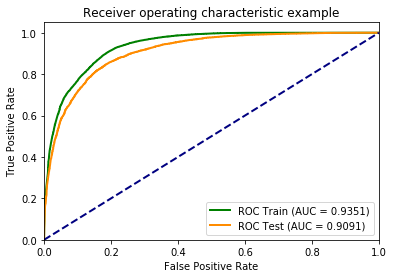

In [16]:
# Plot ROC curves for the training set and the test set
y_train = res_train['label']
res_train['probability'] = [v[1] for v in res_train['probability']]
y_train_pred = res_train['probability']
y_test = res_test['label']
res_test['probability'] = [v[1] for v in res_test['probability']]
y_test_pred = res_test['probability']

plot_roc_curve(y_train, y_train_pred, y_test, y_test_pred)

/Users/hli/anaconda/envs/carnd-term1/lib/python3.5/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


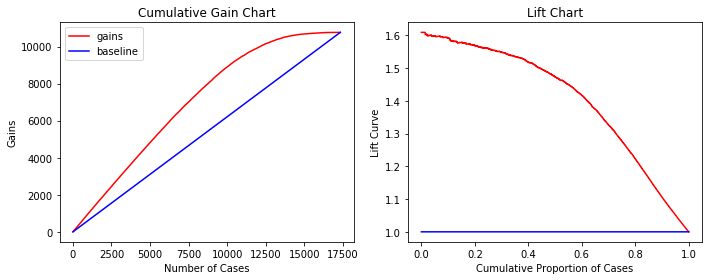

In [17]:
model_gain = calc_cumulative_gains(res_test, 'label',"prediction", "probability")

### Gradient Boosting Trees

In [18]:
# Train a GBT model.
gbt = GBTClassifier(labelCol="label", featuresCol="features", seed=42)

# Run cross-validation, and choose the best set of parameters.
paramGrid = ParamGridBuilder() \
    .addGrid(gbt.maxIter, [20, 50, 100]) \
    .addGrid(gbt.maxDepth, [2, 3, 4]) \
    .build()
    
crossval = CrossValidator(estimator=gbt,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=4) 

cvModel = crossval.fit(train)
print('The best maxIter: {}'.format(cvModel.bestModel._java_obj.getMaxIter()))
print('The best maxDepth: {}'.format(cvModel.bestModel._java_obj.getMaxDepth()))

The best maxIter: 100
The best maxDepth: 4


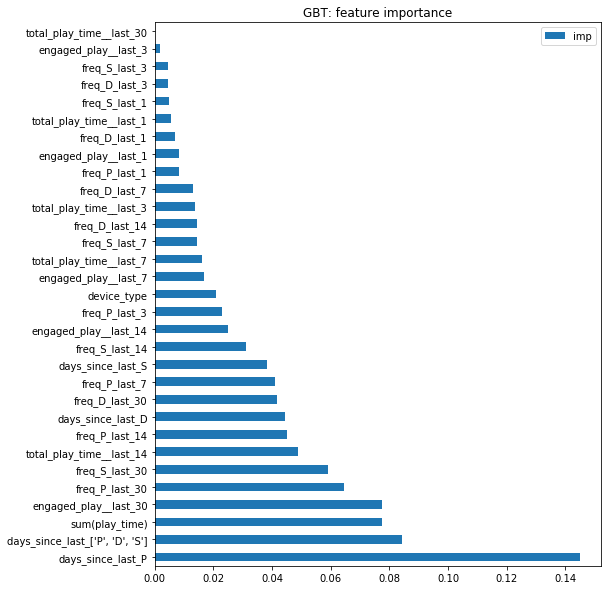

In [19]:
gbtImp = pd.DataFrame(list(zip(selected_features, cvModel.bestModel.featureImportances.toArray())), columns = ['feature', 'imp']).sort_values(by="imp", ascending=False)
ax =  gbtImp.plot.barh(figsize=(8, 10))
t = np.arange(gbtImp.shape[0])
ax.set_yticks(t)
ax.set_yticklabels(gbtImp['feature'])
ax.set_title("GBT: feature importance")
plt.show()

In [20]:
#### predict and evaluate performance

# Predict train data
predictions_train = cvModel.transform(train)

# Select example rows to display.
predictions_train.select("probability","prediction", "label", "features").show(5)
res_train = predictions_train.select("probability","prediction", "label").toPandas()


# Predict test data
predictions_test = cvModel.transform(test)

# Select example rows to display.
predictions_test.select("probability","prediction", "label", "features").show(5)
res_test = predictions_test.select("probability","prediction", "label").toPandas()

+--------------------+----------+-----+--------------------+
|         probability|prediction|label|            features|
+--------------------+----------+-----+--------------------+
|[0.75723280607200...|       0.0|    0|(31,[0,1,2,3,4,5,...|
|[0.67561382125307...|       0.0|    0|(31,[0,1,2,3,4,5,...|
|[0.90988538041470...|       0.0|    0|(31,[0,1,2,3,4,5,...|
|[0.71088501480062...|       0.0|    0|(31,[0,1,2,3,4,5,...|
|[0.24484928770696...|       1.0|    0|(31,[0,1,2,3,4,5,...|
+--------------------+----------+-----+--------------------+
only showing top 5 rows

+--------------------+----------+-----+--------------------+
|         probability|prediction|label|            features|
+--------------------+----------+-----+--------------------+
|[0.76059862698809...|       0.0|    0|(31,[0,1,2,3,4,5,...|
|[0.93273234221227...|       0.0|    0|(31,[0,1,2,3,4,6,...|
|[0.81818898731905...|       0.0|    0|(31,[0,1,2,3,4,7,...|
|[0.91059785700770...|       0.0|    0|(31,[0,1,2,3,4,7,...|

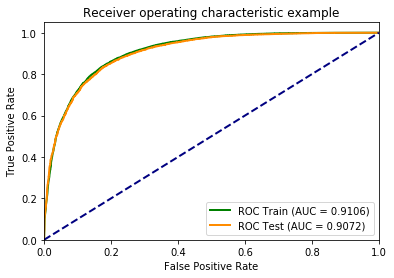

In [21]:
# Plot ROC curves for the training set and the test set
y_train = res_train['label']
res_train['probability'] = [v[1] for v in res_train['probability']]
y_train_pred = res_train['probability']
y_test = res_test['label']
res_test['probability'] = [v[1] for v in res_test['probability']]
y_test_pred = res_test['probability']

plot_roc_curve(y_train, y_train_pred, y_test, y_test_pred)

/Users/hli/anaconda/envs/carnd-term1/lib/python3.5/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


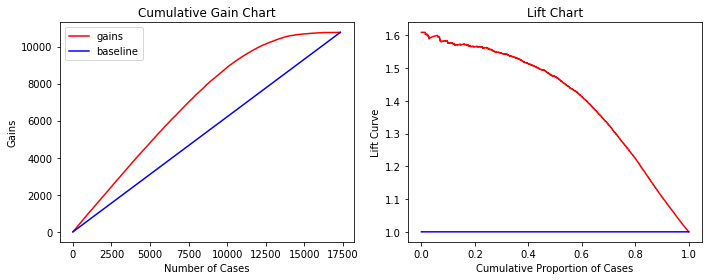

In [22]:
model_gain = calc_cumulative_gains(res_test, 'label',"prediction", "probability")